<a href="https://colab.research.google.com/github/OumGhaith/OumGhaith/blob/main/Real_Time_Human_Activity_Classification_with_Pose_Keypoints_and_LSTM_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===== Step 1: Setup and download dataset =====
!pip install mediapipe tensorflow opencv-python kaggle --quiet

from google.colab import files
import os

# Upload your kaggle.json API token (from your Kaggle account)
files.upload()  # Upload kaggle.json here

# Move to correct location for Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download KTH dataset (small action dataset)
!kaggle datasets download -d alexeychinyaev/kth-video-dataset

# Unzip
!unzip -q kth-video-dataset.zip -d ./kth_data

print("Dataset downloaded and extracted to ./kth_data")

# ===== Step 2: Choose a few classes to speed up training =====
# Example classes: walking, jogging, running
selected_classes = ["walking", "jogging", "running"]
data_path = "./kth_data/kth-video-dataset"

import shutil

# Move selected classes to a new folder
os.makedirs("./kth_subset", exist_ok=True)
for cls in selected_classes:
    src = os.path.join(data_path, cls)
    dst = os.path.join("./kth_subset", cls)
    shutil.copytree(src, dst)

print("Subset of classes prepared:", selected_classes)

# ===== Step 3: MediaPipe Pose keypoint extraction =====
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

def extract_keypoints(video_path, max_frames=50):
    cap = cv2.VideoCapture(video_path)
    keypoints_seq = []
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)
        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints_seq.append(keypoints)
        count += 1
    cap.release()
    return np.array(keypoints_seq)

# ===== Step 4: Prepare sequences and labels =====
X, y = [], []
class_map = {cls:i for i, cls in enumerate(selected_classes)}

for cls in selected_classes:
    folder = os.path.join("./kth_subset", cls)
    for file in os.listdir(folder):
        if file.endswith(".avi"):
            path = os.path.join(folder, file)
            seq = extract_keypoints(path)
            if len(seq) == 0:
                continue
            X.append(seq)
            y.append(class_map[cls])

# Pad sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, padding='post', dtype='float32')
y = np.array(y)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

print("Data prepared: X shape =", X.shape, "y shape =", y.shape)

# ===== Step 5: Build small LSTM classifier =====
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ===== Step 6: Train quickly (demo) =====
model.fit(X, y, epochs=10, batch_size=2, validation_split=0.2)

print("Training finished. Model ready for evaluation or poster visualizations!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have pr

Saving accuracy training and validation densenet.jpg to accuracy training and validation densenet.jpg
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open kth-video-dataset.zip, kth

FileNotFoundError: [Errno 2] No such file or directory: './kth_data/kth-video-dataset/walking'

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
# Create kaggle.json directly in Colab
kaggle_json = {
    "username": "yousrakateb",
    "key": "KGAT_959b481b1951f0215c516396b6088b56"
}

import json
with open("/content/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

print("kaggle.json created successfully!")


kaggle.json created successfully!


In [5]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Test Kaggle API
!kaggle datasets list | head -n 5


ref                                                           title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)          1289021  2025-11-11 09:43:05.933000          15053        342  1.0              
ajinkyachintawar/sales-and-customer-behaviour-insights        Sales & Customer Behaviour Insights                 57108  2025-12-13 09:22:09.340000            746         28  1.0              
kundanbedmutha/exam-score-prediction-dataset                  Exam Score Prediction Dataset                      325454  2025-11-28 07:29:01.047000           4799         93  1.0              


In [6]:
!kaggle datasets download -d alexeychinyaev/kth-video-dataset
!unzip -q kth-video-dataset.zip -d ./kth_data


Dataset URL: https://www.kaggle.com/datasets/alexeychinyaev/kth-video-dataset
License(s): unknown
 97% 442M/456M [00:06<00:00, 64.2MB/s]
100% 456M/456M [00:06<00:00, 72.4MB/s]


In [7]:
# Unzip the dataset
!unzip -q kth-video-dataset.zip -d ./kth_data

# Check the folders
!ls ./kth_data/kth-video-dataset


replace ./kth_data/boxing/person01_boxing_d4_uncomp.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
ls: cannot access './kth_data/kth-video-dataset': No such file or directory


In [8]:
# Unzip all files, overwrite if they already exist, and do it quietly
!unzip -oq kth-video-dataset.zip -d ./kth_data

# List the folders to confirm
!ls ./kth_data/kth-video-dataset


ls: cannot access './kth_data/kth-video-dataset': No such file or directory


In [9]:
!ls ./kth_data
!ls


boxing	handwaving  jogging  running  walking
'accuracy training and validation densenet.jpg'   kth-video-dataset.zip
 kth_data					  sample_data
 kth_subset


In [11]:
data_path = "./kth_data"  # instead of ./kth_data/kth-video-dataset


In [12]:
import shutil
import os

selected_classes = ["walking", "jogging", "running"]
os.makedirs("./kth_subset", exist_ok=True)

for cls in selected_classes:
    src = os.path.join(data_path, cls)
    dst = os.path.join("./kth_subset", cls)
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("Subset prepared:", selected_classes)


Subset prepared: ['walking', 'jogging', 'running']


In [14]:
!pip install --upgrade --force-reinstall numpy==1.25.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 51.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [15]:
# Install a compatible NumPy version already built for Colab
!pip install numpy==1.24.4 --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [1]:
import numpy as np
import tensorflow as tf
import mediapipe as mp
# Continue with your keypoint extraction and LSTM training



In [2]:
# ===== Step 1: Install dependencies =====
!pip install mediapipe tensorflow opencv-python --quiet
import numpy as np
import tensorflow as tf
import mediapipe as mp
# ===== Step 2: Import libraries =====
import cv2
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# ===== Step 3: Setup MediaPipe Pose =====
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

# ===== Step 4: Extract keypoints from a video =====
def extract_keypoints(video_path, max_frames=50):
    cap = cv2.VideoCapture(video_path)
    keypoints_seq = []
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)
        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints_seq.append(keypoints)
        count += 1
    cap.release()
    return np.array(keypoints_seq)

# ===== Step 5: Prepare sequences and labels =====
X, y = [], []
selected_classes = ["walking", "jogging", "running"]
class_map = {cls:i for i, cls in enumerate(selected_classes)}

for cls in selected_classes:
    folder = os.path.join("./kth_subset", cls)
    for file in os.listdir(folder):
        if file.endswith(".avi"):
            path = os.path.join(folder, file)
            seq = extract_keypoints(path)
            if len(seq) == 0:
                continue
            X.append(seq)
            y.append(class_map[cls])

# Pad sequences to same length
X = pad_sequences(X, padding='post', dtype='float32')
y = to_categorical(y)

print("Data prepared: X shape =", X.shape, "y shape =", y.shape)

# ===== Step 6: Build small LSTM classifier =====
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ===== Step 7: Train model =====
model.fit(X, y, epochs=10, batch_size=2, validation_split=0.2)

print("Training finished. Model ready for evaluation or visualization!")


Data prepared: X shape = (227, 49, 99) y shape = (227, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 49, 99)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,179 (164.76 KB)

 Trainable params: 42,179 (164.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4541 - loss: 1.0279 - val_accuracy: 0.0435 - val_loss: 1.2992
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6680 - loss: 0.8717 - val_accuracy: 0.1087 - val_loss: 1.1024
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7574 - loss: 0.6839 - val_accuracy: 0.3478 - val_loss: 1.3963
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6800 - loss: 0.7423 - val_accuracy: 0.6957 - val_loss: 0.8888
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7104 - loss: 0.6628 - val_accuracy: 0.5217 - val_loss: 0.8619
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7707 - loss: 0.5682 - val_accuracy: 0.5217 - val_loss: 1.0999
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7105 - loss: 0.6207 - val_accuracy: 0.5652 - val_loss: 0.8190
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7647 - loss: 0.5182 - val_accuracy: 0.8043 - v

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7495 - loss: 0.5381 - val_accuracy: 0.7609 - val_loss: 0.5861
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7669 - loss: 0.5379 - val_accuracy: 0.8696 - val_loss: 0.5411
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8846 - loss: 0.3851 - val_accuracy: 0.3043 - val_loss: 1.0605
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6796 - loss: 0.6269 - val_accuracy: 0.5870 - val_loss: 0.6921
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8293 - loss: 0.4465 - val_accuracy: 0.9130 - val_loss: 0.4819
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7876 - loss: 0.4676 - val_accuracy: 0.5870 - val_loss: 0.7753
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7984 - loss: 0.4499 - val_accuracy: 0.8043 - val_loss: 0.5544
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8586 - loss: 0.3407 - val_accuracy: 0.8043 - v

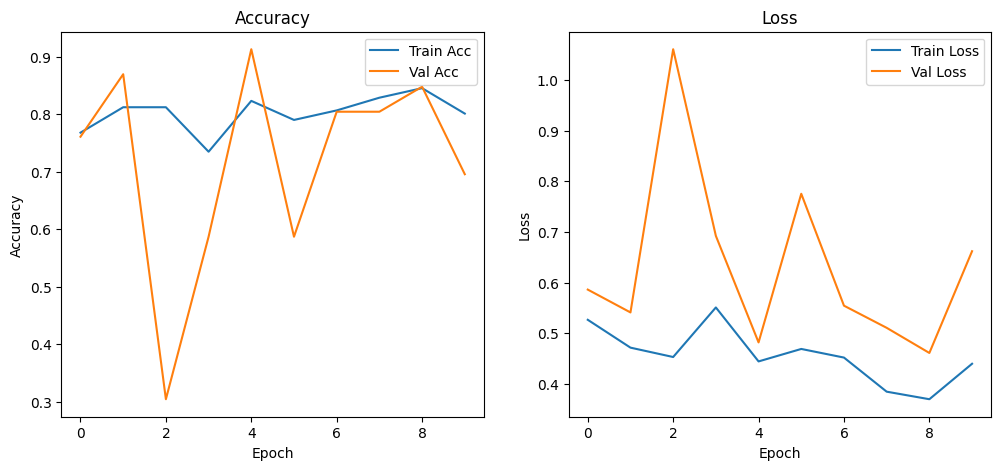

In [4]:
# Train the model and save history
history = model.fit(X, y, epochs=10, batch_size=2, validation_split=0.2)

# Now you can plot accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


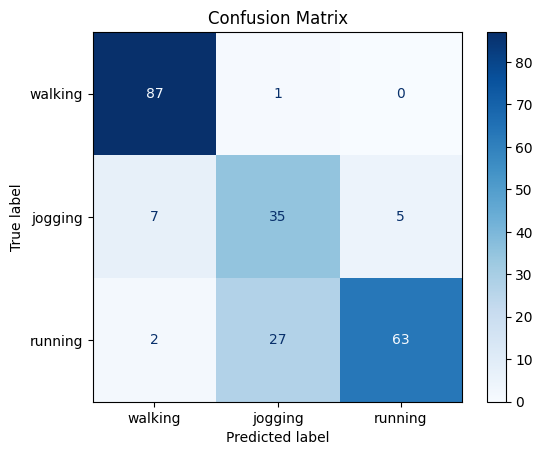

              precision    recall  f1-score   support

     walking       0.91      0.99      0.95        88
     jogging       0.56      0.74      0.64        47
     running       0.93      0.68      0.79        92

    accuracy                           0.81       227
   macro avg       0.80      0.81      0.79       227
weighted avg       0.84      0.81      0.82       227



In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# True and predicted labels
y_true = np.argmax(y, axis=1)
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)


In [6]:
import time

num_trials = 5
start = time.time()
for _ in range(num_trials):
    _ = model.predict(X[:1])
end = time.time()
avg_inference_time = (end - start) / num_trials
print(f"Average inference time per video: {avg_inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Average inference time per video: 0.0966 seconds


In [7]:
plt.savefig("accuracy_loss.png")
disp.figure_.savefig("confusion_matrix.png")


<Figure size 640x480 with 0 Axes>

In [8]:
with open("classification_report.txt", "w") as f:
    f.write(report)


In [9]:
from sklearn.metrics import classification_report
import numpy as np

# True labels
y_true = np.argmax(y, axis=1)  # convert one-hot to class index

# Predicted labels
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=selected_classes)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     walking       0.91      0.99      0.95        88
     jogging       0.56      0.74      0.64        47
     running       0.93      0.68      0.79        92

    accuracy                           0.81       227
   macro avg       0.80      0.81      0.79       227
weighted avg       0.84      0.81      0.82       227



In [10]:
# GPU memory usage (if using GPU runtime)
!nvidia-smi

# Python RAM usage
import psutil
ram_gb = psutil.virtual_memory().used / 1e9
print(f"Approximate RAM used: {ram_gb:.2f} GB")


/bin/bash: line 1: nvidia-smi: command not found
Approximate RAM used: 1.66 GB


In [12]:
save_the_model = model.save("lstm_kth_model.h5")  # saves trained model for later use
